In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from scipy.signal import decimate

import emd

from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_branching, sim_asine_oscillation, sim_autoregressive
from timescales.fit import fit_psd, convert_knee_val
from timescales.decompose import CAD, CADGroup, AMD, ar_psd

### Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.

The second half of this notebook introduces an iterative process to automatically estimate the periodic model.

#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = e^{j \phi_{i}} e^{j 2\pi f_{i} n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

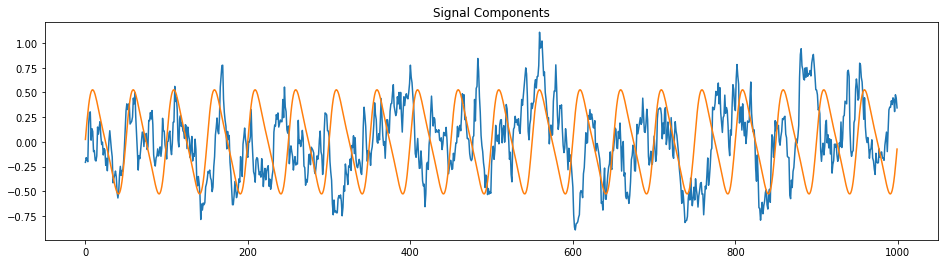

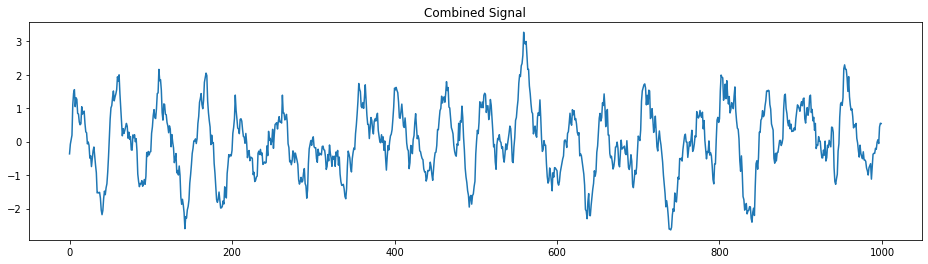

In [2]:
# Simulate
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
xs = np.arange(fs)

lfp = sim_branching(n_seconds, fs, tau, 100)
osc = sim_asine_oscillation(xs, fs, 20, .25, -.49, 1)

osc_var = .5
lfp = normalize_sig(lfp, 0, (1-osc_var)) 
osc = normalize_sig(osc, 0, (osc_var)) 

sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);


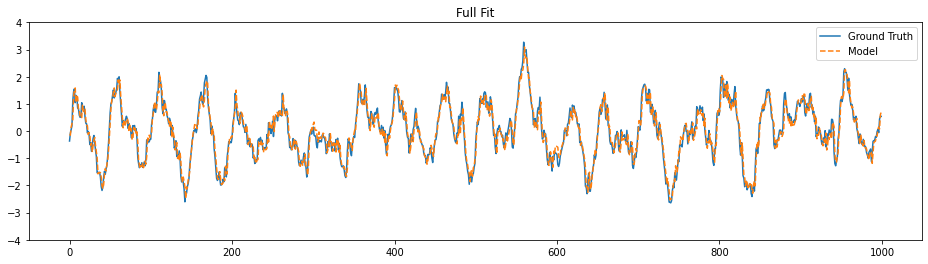

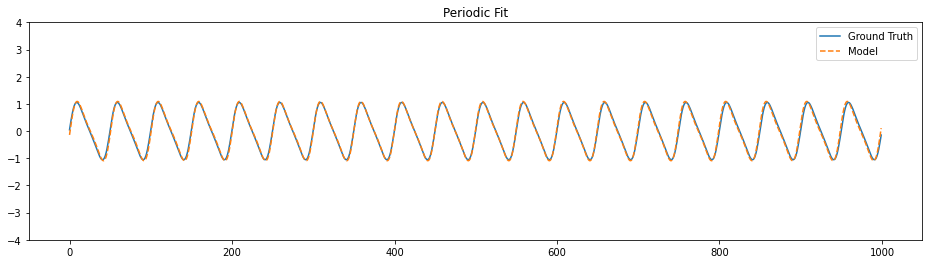

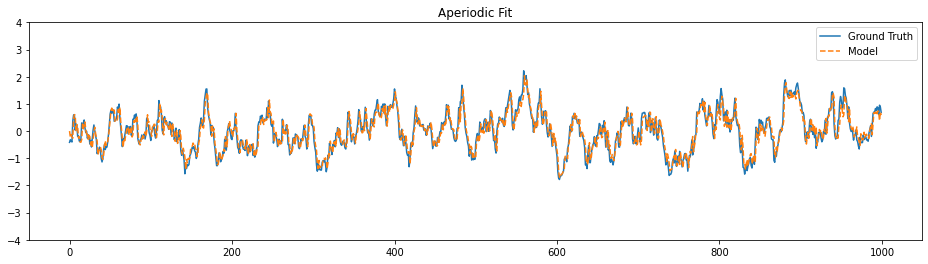

In [3]:
# Fit
osc_order = 1
ar_order = 2

cad = CAD(sig, fs, osc_order, ar_order)
cad.fit()

# Plot Results
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(sig, label='Ground Truth')
plt.plot(cad.full_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(cad.osc_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(cad.ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

# Asymmetrical Mode Decomposition

Complex waveform shapes may be fit using an iterative process in which asymmetrical waves are fit to a signal in ascending (or descending) frequency order. This method allows periodic and aperiodic components to be separated in the time domain, and timescale to be more accurately quantified using autoregressive PSD.

This process involves optimizing the oscillatory term in the CAD equation using tiny asine oscillators.

1. Define a frequency range to step through (i.e. np.arange(100))
2. For each frequency in the range: 
   <br> a. optimize the best non-sinusoidal wave that fits the signal
   <br> b. subtract the wave from the signal and continue

Text(0.5, 1.0, 'Rat Hippocampal Rhythms')

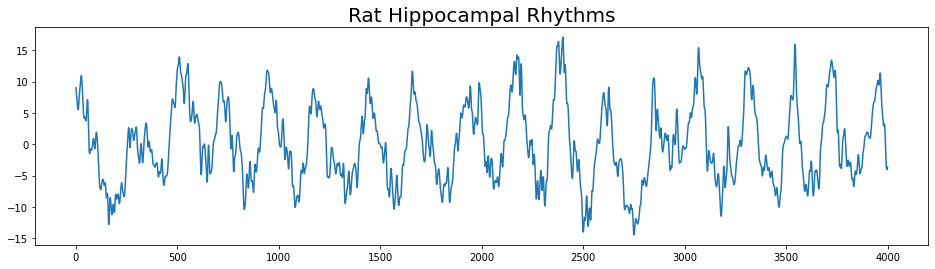

In [4]:
# Load data
file_path_dat = "/home/rph/Projects/bycycle/sim_nbs/crcns/hc2/ec013.527/ec013.527.dat"
num_channels = 31
fs = 20000

with open(file_path_dat, mode='rb') as file: 
    file_content = file.read()
    
sig = np.frombuffer(file_content, dtype=np.short)
sig = np.reshape(sig, (-1, num_channels)).T

sig = sig[20] / 100

# Slice and downsample
sig_down = decimate(sig, 10)
fs = fs/10
sig_down = filter_signal(sig_down, fs, 'lowpass', 200, remove_edges=False)

# Plot
start = 9000
end = start+4000
sig = sig_down[start:end]

plt.figure(1, figsize=(16, 4))
plt.plot(sig)
plt.title('Rat Hippocampal Rhythms', size=20)

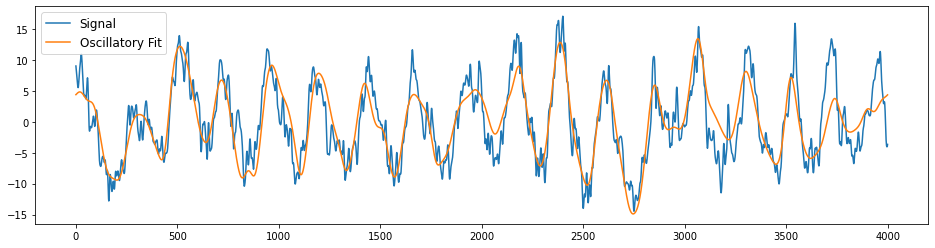

In [5]:
freqs = np.linspace(0, 100, 201) # np.logspace(np.log(1), np.log(10), 100)

amd = AMD(sig, fs)
amd.fit(freqs)

sig_pe = amd.sig_pe[
    np.argsort(amd.sig_pe.var(axis=1))[::-1][:10]
].sum(axis=0)

sig_ap = sig - sig_pe

# Plot
plt.figure(0, figsize=(16, 4))
plt.plot(sig, label='Signal')
plt.plot(sig_pe, label='Oscillatory Fit')
#plt.plot(sig_ap, label='Residuals (Aperiodic)')
plt.legend(fontsize=12);

### Comparison to EMD

AMD is much slower than EMD, but allows for many modes than EMD. In AMD, each frequency is assigned one mode. AMD modes associated with an oscillatory band are combined to estimate the periodic component of the signal. This typically

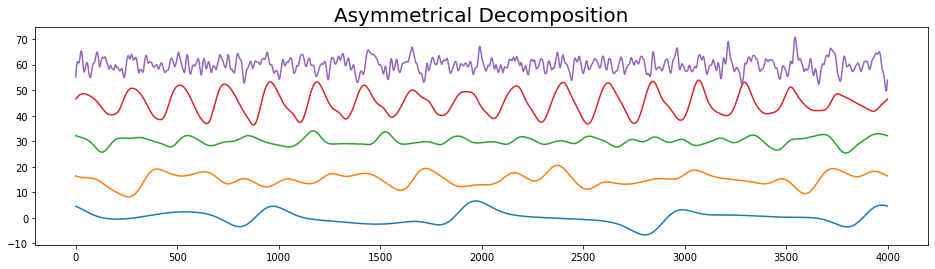

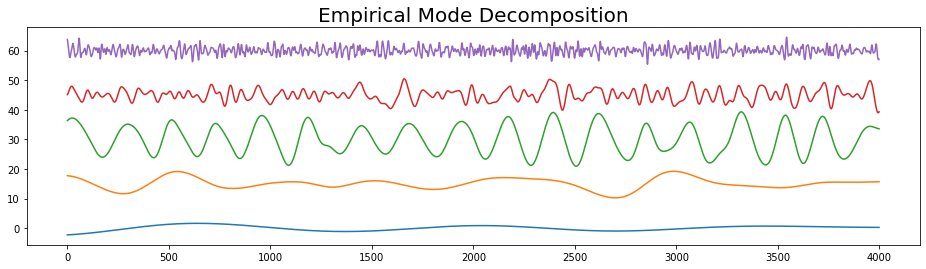

In [6]:
# Plot 
n_bins = 5
sig_clust = np.zeros((n_bins, len(sig)))

inds = np.linspace(0, len(freqs), n_bins+1).astype(int)
inds = np.array([0, 5, 10, 15, 20, 200])
l_inds, u_inds = inds[:-1], inds[1:]

for i, (l, u) in enumerate(zip(l_inds, u_inds)):
    sig_clust[i] = amd.sig_pe[l:u].sum(axis=0)
    
plt.figure(0, figsize=(16, 4))
plt.title(f'Asymmetrical Decomposition', size=20)
j = 0
for i in sig_clust:
    plt.plot(i+j)
    j += 15
    
    
# EMD for comparison
x = emd.sift.iterated_mask_sift(sig, max_imfs=5)
x = x.T[::-1]

plt.figure(1, figsize=(16, 4))
plt.title(f'Empirical Mode Decomposition', size=20)
j = 0
for i in x:
    plt.plot(i+j)
    j+=15

<Figure size 432x288 with 0 Axes>

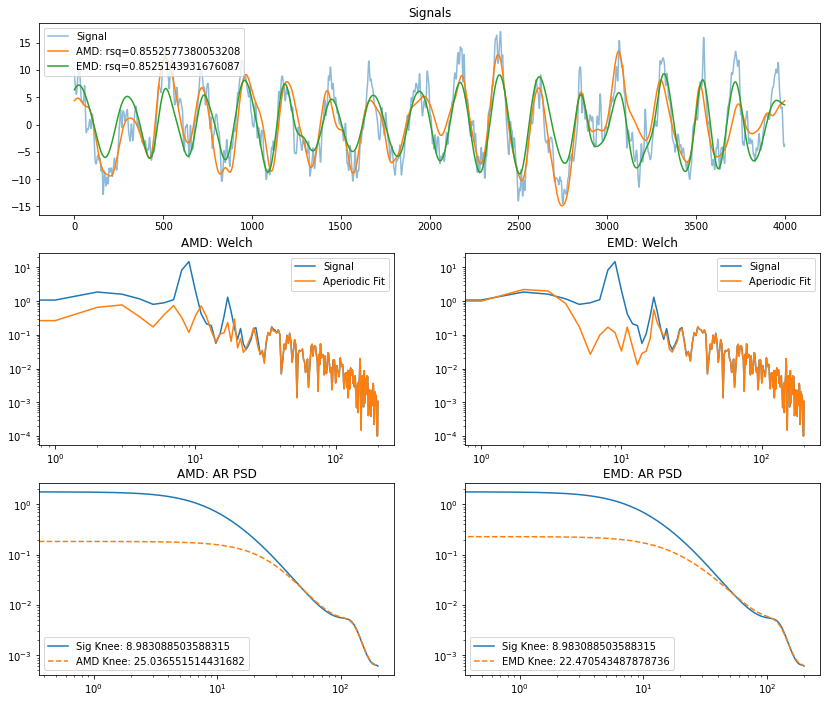

In [9]:
order = 8

# Plot
fooof_init = {'max_n_peaks':0}

inds = np.argsort(amd.sig_pe.var(axis=1))[::-1][:10]

sig_pe_amd = amd.sig_pe[inds].sum(axis=0)
sig_ap_amd = sig-sig_pe_amd

sig_pe_emd = x[2]
sig_ap_emd = sig-sig_pe_emd

f_ar_sig, p_ar_sig = ar_psd(sig, fs, order, f_range=(0, 200))
f_ar_emd_ap, p_ar_emd_ap= ar_psd(sig_ap_emd, fs, order, f_range=(0, 200))
f_ar_amd_ap, p_ar_amd_ap = ar_psd(sig_ap_amd, fs, order, f_range=(0, 200))

_, k_sig, _ = fit_psd(f_ar_sig, p_ar_sig, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))
_, k_amd, _ = fit_psd(f_ar_amd_ap, p_ar_amd_ap, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))
_, k_emd, _ = fit_psd(f_ar_emd_ap, p_ar_emd_ap, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))

r_sq_amd = np.corrcoef(sig, sig_pe_amd)[0][1]
r_sq_emd = np.corrcoef(sig, sig_pe_emd)[0][1]

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[1, 1:])
ax3 = fig.add_subplot(gs[2, :1])
ax4 = fig.add_subplot(gs[2, 1:])

# Plot AMD spectra
order = 8
plt.figure(0, figsize=(6, 4))

f, p = compute_spectrum(sig, fs, f_range=(0, 200))
ax1.loglog(f, p, label='Signal')

f, p = compute_spectrum(sig_ap_amd, fs, f_range=(0, 200))
ax1.loglog(f, p, label='Aperiodic Fit')

ax1.set_title('AMD: Welch')
ax1.legend()

ax3.set_title('AMD: AR PSD')
f, p = compute_spectrum(sig, fs, f_range=(0, 200))

ax3.loglog(f_ar_sig, p_ar_sig, label=f'Sig Knee: {k_sig}')
ax3.loglog(f_ar_amd_ap, p_ar_amd_ap, ls='--', label=f'AMD Knee: {k_amd}')
ax3.legend()

# Plot EMD Spectra
plt.figure(1, figsize=(6, 4))

sig_pe_emd = x[2] 
sig_ap_emd = sig-sig_pe_emd

f, p = compute_spectrum(sig, fs, f_range=(0, 200))
ax2.loglog(f, p, label='Signal')

f, p = compute_spectrum(sig_ap_emd, fs, f_range=(0, 200))
ax2.loglog(f, p, label='Aperiodic Fit')

ax2.set_title('EMD: Welch')
ax2.legend()

ax4.set_title('EMD: AR PSD')
ax4.loglog(f_ar_sig, p_ar_sig, label=f'Sig Knee: {k_sig}')
ax4.loglog(f_ar_emd_ap, p_ar_emd_ap, ls='--', label=f'EMD Knee: {k_emd}')
ax4.legend()

# Plot signals
ax0.plot(sig, label='Signal', alpha=.5)
ax0.plot(sig_pe_amd, label=f'AMD: rsq={r_sq_amd}')
ax0.plot(sig_pe_emd, label=f'EMD: rsq={r_sq_emd}')
ax0.set_title('Signals')
ax0.legend();